# Imports

In [232]:
import numpy as np
import pandas as pd 
import random 

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits import mplot3d

from scipy.special import softmax
from scipy.spatial.distance import cdist

import torch
import torch.nn as nn
import torch.optim as optim

from timeit import default_timer as timer
import sys

from sklearn.decomposition import PCA

from scipy.stats import norm

import plotly.graph_objects as go

# Dataset

In [123]:
df = pd.read_csv('ESS8_data.csv')

X = df[['SD1', 'PO1', 'UN1', 'AC1', 'SC1',
       'ST1', 'CO1', 'UN2', 'TR1', 'HD1', 'SD2','BE1','AC2', 'SC2', 'ST2',
       'CO2', 'PO2', 'BE2', 'UN3', 'TR2','HD2']].iloc[range(40000),:]

X = X.to_numpy().T

# Shapes of data:
N, M = X.T.shape

# Number of archetypes
K = 5

# Number of iterations
n_iter = 10000

# Define helper funcitons

In [124]:
def _apply_constraints_AB(A):
    m = nn.Softmax(dim=0)
    return m(A)


def _apply_constraints_beta(b):    
    m = nn.Softmax(dim=0)
    return torch.cumsum(m(b), dim=0)[:len(b)-1]


def _apply_constraints_sigma(sigma):
    m = nn.Softplus()
    return m(sigma)

    
def _calculate_alpha(b,J):
    b_j = torch.cat((torch.tensor([0.0]),b),0)
    b_j_plus1 = torch.cat((b,torch.tensor([1.0])),0)
    alphas = (b_j_plus1+b_j)/2
    return alphas


def _calculate_X_tilde(X,alphas):
    X_tilde = alphas[X-1]
    return X_tilde
    


def _calculate_X_hat(X_tilde,A,B):
    return X_tilde@B@A



def _calculate_D(b,X_hat,sigma):
    
    D = torch.rand(len(b)+2,len(X_hat),len(X_hat[0,:]))

    for j in range(len(b)+2):
        if j == 0:
            D[j] = torch.tensor(np.matrix(np.ones((len(X_hat),len(X_hat[0,:]))) * (-np.inf)))
        elif j == len(b)+1:
            D[j] = torch.tensor(np.matrix(np.ones((len(X_hat),len(X_hat[0,:]))) * (np.inf)))
        else:
            D[j] = (b[j-1]-X_hat)/sigma

    return D


def _calculate_loss(D,X):

    N = len(X)
    M = len(X[0,:])
    stand_norm = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
    
    D_cdf = stand_norm.cdf(D)
    P = D_cdf[1:]-D_cdf[:len(D)-1]
    
    inverse_log_P = -torch.log(P)
    
    N_arange = [n for n in range(N) for m in range(M)]
    M_arange = [m for m in range(M) for n in range(N)]

    loss = torch.sum(inverse_log_P[torch.flatten(X)-1,N_arange,M_arange])
    
    return loss


def _error(Xt,A_non_constraint,B_non_constraint,b_non_constraint,sigma_non_constraint,J):
    
    A = _apply_constraints_AB(A_non_constraint)
    B = _apply_constraints_AB(B_non_constraint)
    b = _apply_constraints_beta(b_non_constraint)
    sigma = _apply_constraints_sigma(sigma_non_constraint)
    alphas = _calculate_alpha(b,J)
    
    X_tilde = _calculate_X_tilde(Xt,alphas)
    X_hat = _calculate_X_hat(X_tilde,A,B)
    D = _calculate_D(b,X_hat,sigma)
    loss = _calculate_loss(D,Xt)

    return loss
    
    
def _compute_archetypes(X, K, n_iter, lr, mute):

    N, _ = X.T.shape
    J = int((np.max(X)-np.min(X))+1)
    Xt = torch.autograd.Variable(torch.tensor(X), requires_grad=False)
    A_non_constraint = torch.autograd.Variable(torch.rand(K, N), requires_grad=True)
    B_non_constraint = torch.autograd.Variable(torch.rand(N, K), requires_grad=True)
    b_non_constraint = torch.autograd.Variable(torch.rand(J), requires_grad=True)
    sigma_non_constraint = torch.autograd.Variable(torch.rand(1), requires_grad=True)
    
    prev_loss = 0
    
    optimizer = optim.Adam([A_non_constraint, 
                            B_non_constraint, 
                            b_non_constraint, 
                            sigma_non_constraint], amsgrad = True, lr = lr)
    
    for i in range(n_iter):
        optimizer.zero_grad()
        L = _error(Xt,A_non_constraint,B_non_constraint,b_non_constraint,sigma_non_constraint,J)
        if i%10 == 0:   
            print(f"itt: {i}")
            print(f"loss improvment: {prev_loss-L}")
            prev_loss = L
        L.backward()
        optimizer.step() 
        
    # Compute the final error
    loss_f = _error(Xt,A_non_constraint,B_non_constraint,b_non_constraint,sigma_non_constraint,J).item()
    Z_f = (X@_apply_constraints_AB(B_non_constraint).detach().numpy())
    A_f = _apply_constraints_AB(A_non_constraint).detach().numpy()
    B_f = _apply_constraints_AB(B_non_constraint).detach().numpy()
    b_f = _apply_constraints_beta(b_non_constraint)
    alphas_f = _calculate_alpha(b_f,J)
    X_tilde_f = _calculate_X_tilde(Xt,alphas_f).detach().numpy()
    Z_tilde_f = (X_tilde_f@_apply_constraints_AB(B_non_constraint).detach().numpy())
    X_hat_f = _calculate_X_hat(X_tilde_f,A_f,B_f)

    
    print("▣ The final loss was: {0}.".format(round(loss_f,2)))

    print(f"b: {b_f}")
    print(f"alphas: {alphas_f}")
    
    return A_f, B_f, b_f, Z_f, loss_f, X_tilde_f, X_hat_f, Z_tilde_f

In [125]:
A, B, b, Z, RSS, X_hat, X_tilde, Z_tilde = _compute_archetypes(X,5,3000,0.001,False)

itt: 0
loss improvment: -1640761.75
itt: 10
loss improvment: 7364.25
itt: 20
loss improvment: 7278.375
itt: 30
loss improvment: 7183.125
itt: 40
loss improvment: 7083.25
itt: 50
loss improvment: 6981.125
itt: 60
loss improvment: 6879.625
itt: 70
loss improvment: 6779.5
itt: 80
loss improvment: 6681.0
itt: 90
loss improvment: 6585.125
itt: 100
loss improvment: 6491.125
itt: 110
loss improvment: 6399.625
itt: 120
loss improvment: 6310.375
itt: 130
loss improvment: 6223.75
itt: 140
loss improvment: 6139.0
itt: 150
loss improvment: 6056.875
itt: 160
loss improvment: 5976.875
itt: 170
loss improvment: 5899.125
itt: 180
loss improvment: 5823.625
itt: 190
loss improvment: 5750.25
itt: 200
loss improvment: 5679.125
itt: 210
loss improvment: 5610.125
itt: 220
loss improvment: 5542.5
itt: 230
loss improvment: 5477.875
itt: 240
loss improvment: 5414.375
itt: 250
loss improvment: 5353.0
itt: 260
loss improvment: 5293.25
itt: 270
loss improvment: 5235.5
itt: 280
loss improvment: 5179.0
itt: 290
los

In [126]:
print(X_hat.shape)
print(X_tilde.shape)
print(f"X_hat, max: {np.max(X_hat)}, ,min: {np.min(X_hat)}")
print(f"X_tilde, max: {np.max(X_tilde)}, ,min: {np.min(X_tilde)}")

(21, 40000)
(21, 40000)
X_hat, max: 0.9832653999328613, ,min: 0.020006241276860237
X_tilde, max: 0.8442046046257019, ,min: 0.043741874396800995


In [240]:
def _radar_chart(name, Z, columns):

    labels = {}
    label_names = []
    for column in columns:
        column  = column[:2]
        if not column in labels:
            labels[column] = {}
            label_names.append(column)
            column_indexes = []
            for idx, item in enumerate(columns):
                if item[:2] == column:
                    column_indexes.append(idx)
            
            for i in column_indexes:
                for a in range(len(Z.T)):
                    if not a in labels[column]:
                        labels[column][a] = 0
                    labels[column][a] += Z.T[a,i]

            labels[column]["count"] = len(column_indexes)

    archetypes = {}
    for a in range(len(Z.T)):
        archetypes[a] = []
        for label in labels:
            archetypes[a].append(labels[label][a]/labels[label]["count"])
    
    fig = go.Figure()
    a = 1

    print(archetypes)

    for archetype in archetypes:

        fig.add_trace(go.Scatterpolar(
            r=archetypes[archetype],
            theta=label_names,
            fill='toself',
            name=f'Archetype {a}'
        ))
        a += 1

    fig.update_layout(
        polar=dict(
        radialaxis=dict(
        visible=True,
        range=[0, 5]
        )),
        showlegend=False
    )

    fig.show()
                    

columns = ['SD1', 'PO1', 'UN1', 'AC1', 'SC1',
       'ST1', 'CO1', 'UN2', 'TR1', 'HD1', 'SD2','BE1','AC2', 'SC2', 'ST2',
       'CO2', 'PO2', 'BE2', 'UN3', 'TR2','HD2']

_radar_chart("Hey", Z_tilde, columns)

{0: [0.36658310890197754, 0.6609931439161301, 0.22062652309735617, 0.5723015367984772, 0.1390104629099369, 0.7250795364379883, 0.3387324810028076, 0.2715770825743675, 0.6505919694900513, 0.1883692368865013], 1: [0.20777394622564316, 0.4799407571554184, 0.0814741924405098, 0.3711313307285309, 0.08863385021686554, 0.46525536477565765, 0.17440371215343475, 0.12315914034843445, 0.35374122858047485, 0.05540693923830986], 2: [0.1756560280919075, 0.24255596846342087, 0.2088922361532847, 0.1671542376279831, 0.1635749787092209, 0.321450337767601, 0.30520932376384735, 0.30919767916202545, 0.21225015819072723, 0.1601092591881752], 3: [0.4680933505296707, 0.7117892205715179, 0.445751150449117, 0.6849982738494873, 0.47767698764801025, 0.6417506635189056, 0.6046425700187683, 0.5071416944265366, 0.546528697013855, 0.4214886426925659], 4: [0.10368098691105843, 0.4572117328643799, 0.2140680601199468, 0.3113720864057541, 0.2717125415802002, 0.25130098313093185, 0.4678202420473099, 0.45832639932632446, 0

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

# Define 2d plots

In [210]:
def _2dplot(Z,X):
        
        pca = PCA(n_components=2)
        pca.fit(Z.T)
        
        Z_pca = pca.transform(Z.T)
        X_pca = pca.transform(X.T)
        
        #line_1 = []
        #line_2 = []
        #lines = []
        #distances = []
        
        #for arch in Z_pca:
        #    for other in Z_pca:
        #        lines.append([arch[0],arch[1],other[0],other[1]])
        #        distances.append(np.linalg.norm(np.mean([arch,other], axis = 1)))
        #        line_1.append(arch[0])
        #        line_1.append(other[0])
        #        line_2.append(arch[1])
        #        line_2.append(other[1])
        
        plt.rcParams["figure.figsize"] = (10,10)
        #plt.plot(line_1, line_2, '-', c = "red", linewidth=0.5)
        plt.scatter(X_pca[:,0], X_pca[:,1], c ="black", s = 1)
        plt.scatter(Z_pca[:,0], Z_pca[:,1], marker ="^", c ="#2c6c8c", s = 750, label="Archetypes")
        plt.xlabel("Principal Component 1", fontsize=25)
        plt.ylabel("Principal Component 2", fontsize=25)
        plt.legend(prop={'size': 15})
        
        plt.savefig("Scatter-plot Principal Component")
        plt.show()

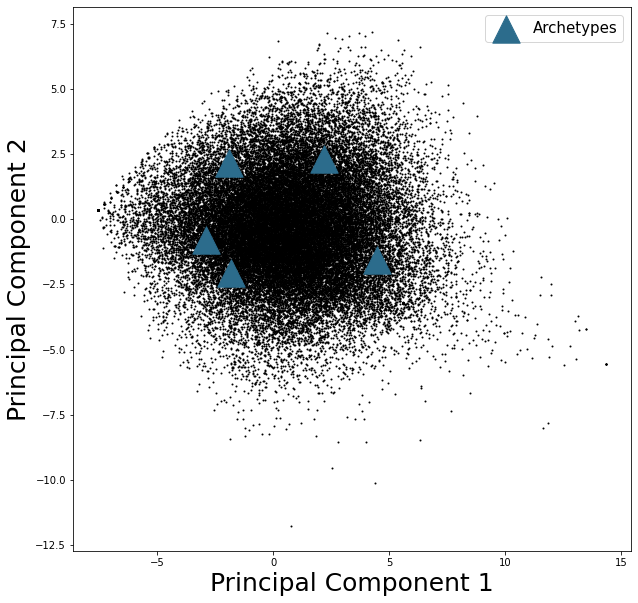

In [211]:
_2dplot(Z,X)

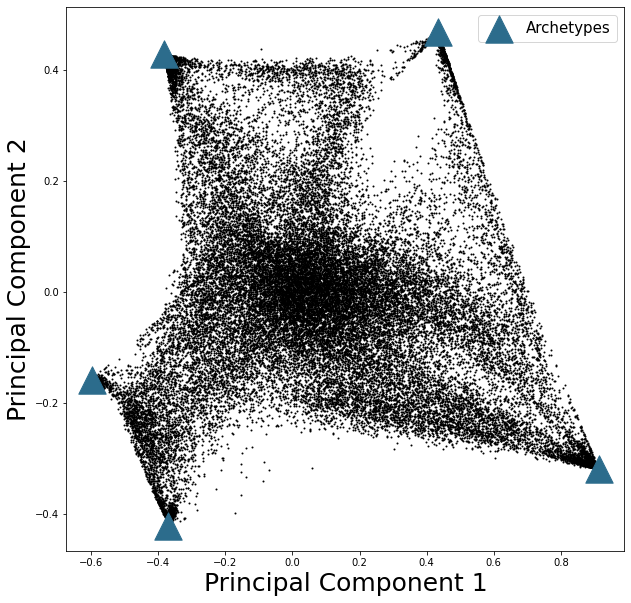

In [212]:
_2dplot(Z_tilde,X_tilde)

# Define 2d plots 2

In [194]:
def _2dplot(Z,X):
        
        fig, axs = plt.subplots(3, 3)

        plt.figure(figsize=(18, 18), dpi=80)

        for i in range(3):
                for j in range(3):
                        axs[i, j].scatter(X[i*3+j,:], X[i*3+j+1,:], c ="black", s = 1)
                        axs[i, j].scatter(Z[i*3+j,:], Z[i*3+j+1,:], marker ="^", c ="#2c6c8c", s = 750, label="Archetypes")
                        axs[i, j].set_title(f"Question {i*3+j+1} and {i*3+j+2}", fontsize=25)
                        axs[i, j].legend(prop={'size': 15})
        

        fig.savefig("OAA Attribute Plot.png")
        plt.show()

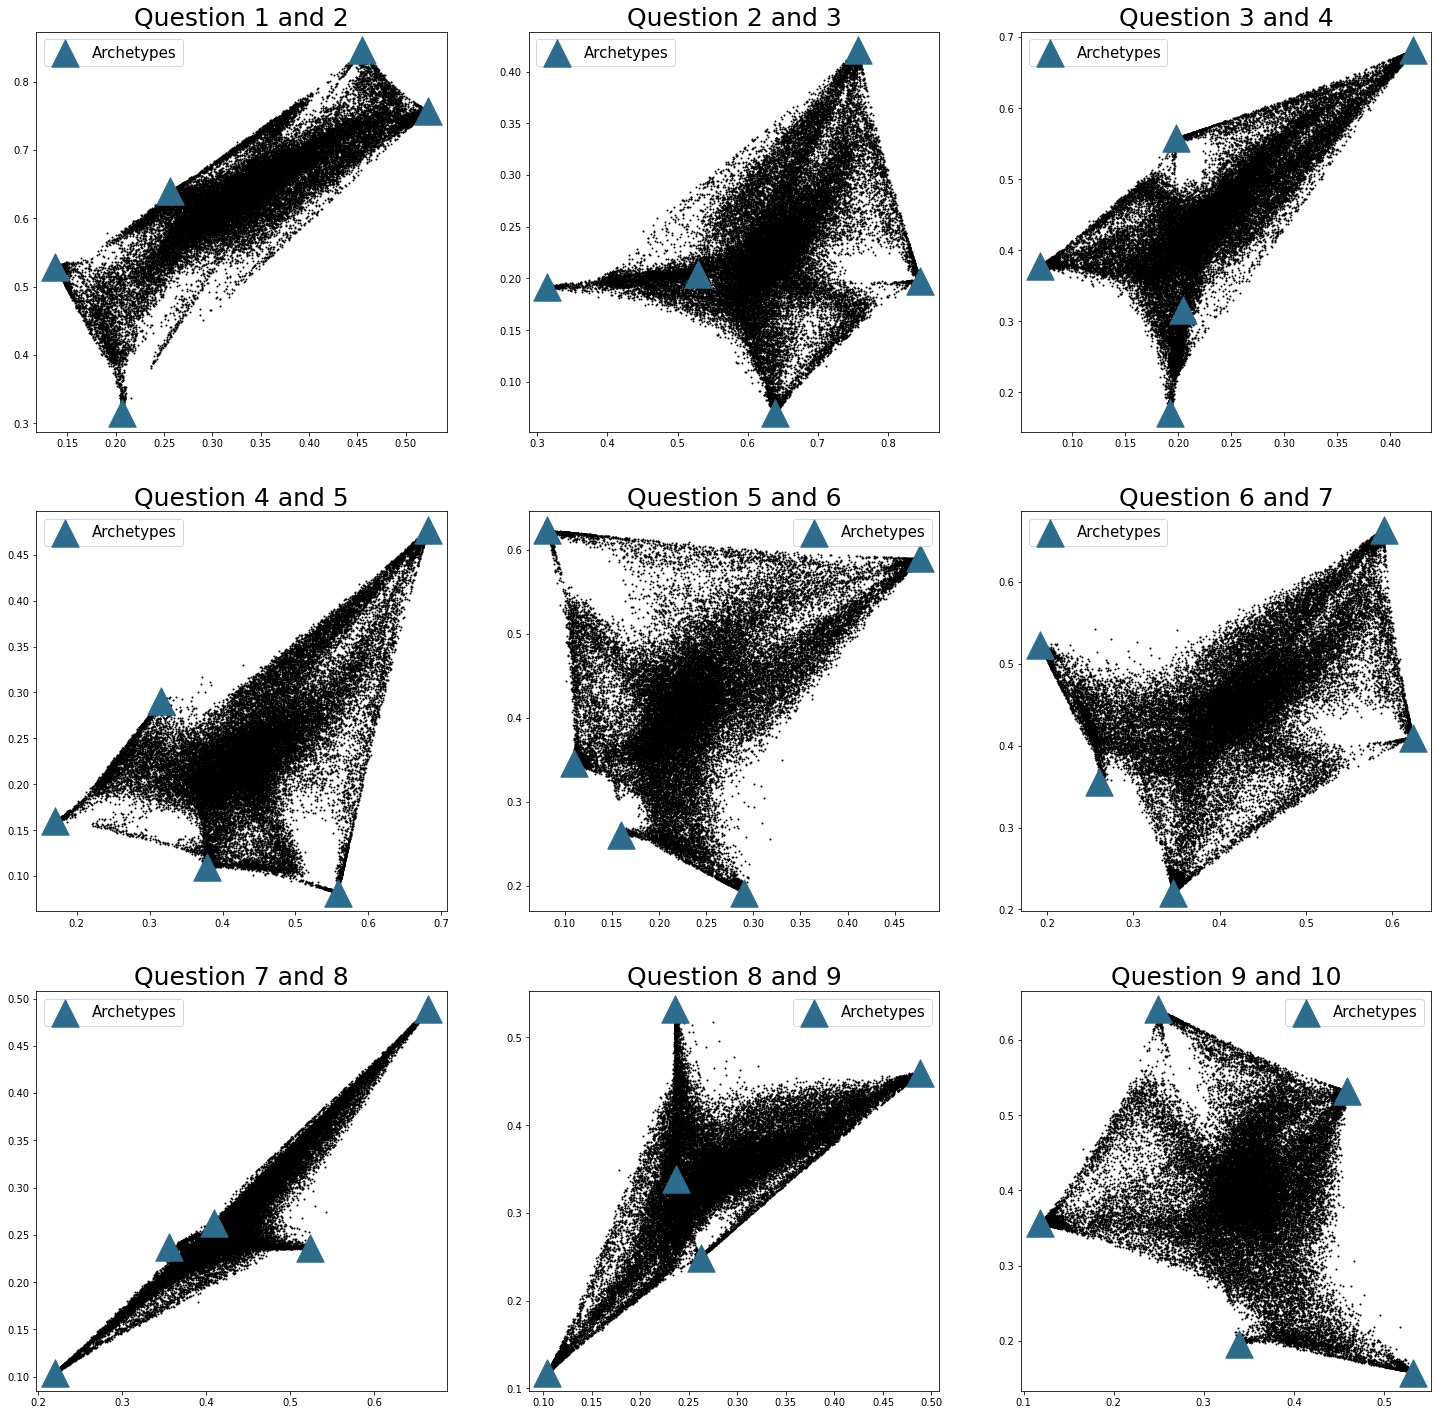

<Figure size 1440x1440 with 0 Axes>

In [195]:
_2dplot(Z_tilde,X_tilde)

# Define 2d plots 3

In [132]:
def _barplot(Z,columns):
    archetype_num = 1
    for archetype in Z.T:
        fig, ax = plt.subplots()
        ax.set_ylabel('Value')
        ax.set_title('Archeype {0}'.format(archetype_num))
        ax.bar(np.arange(len(archetype)),archetype)
        ax.set_xticks(np.arange(len(archetype)))
        ax.set_xticklabels(labels=columns)
        plt.ylim(np.min(Z-1), np.max(Z+1))
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
            
        fig.set_size_inches(8, 8)
            
        plt.show()
            
        archetype_num += 1

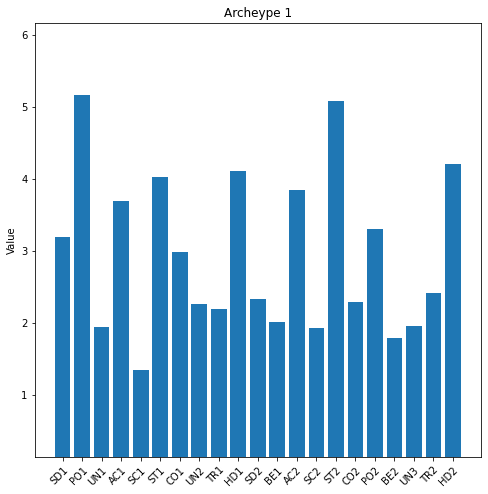

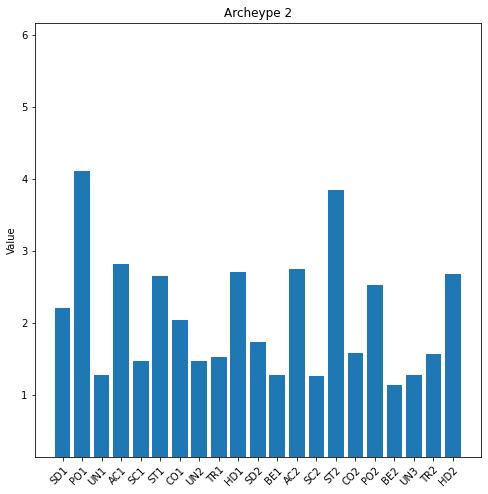

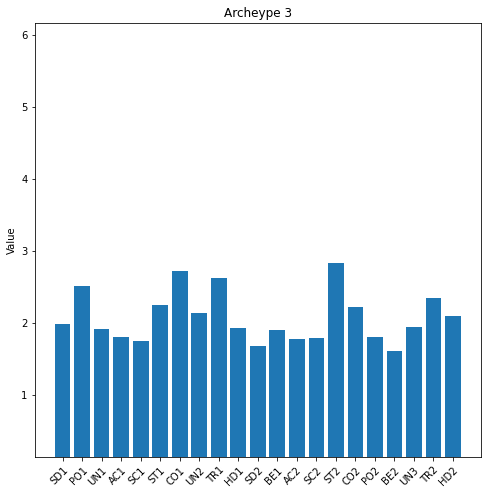

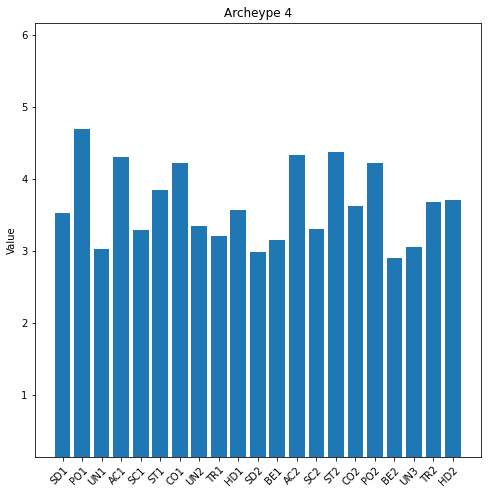

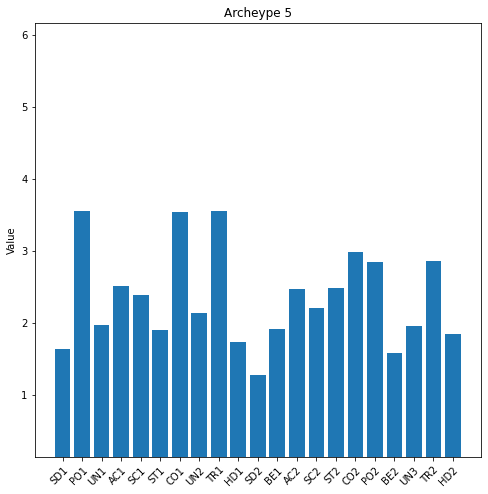

In [133]:
columns = ['SD1', 'PO1', 'UN1', 'AC1', 'SC1',
       'ST1', 'CO1', 'UN2', 'TR1', 'HD1', 'SD2','BE1','AC2', 'SC2', 'ST2',
       'CO2', 'PO2', 'BE2', 'UN3', 'TR2','HD2']

_barplot(Z,columns)

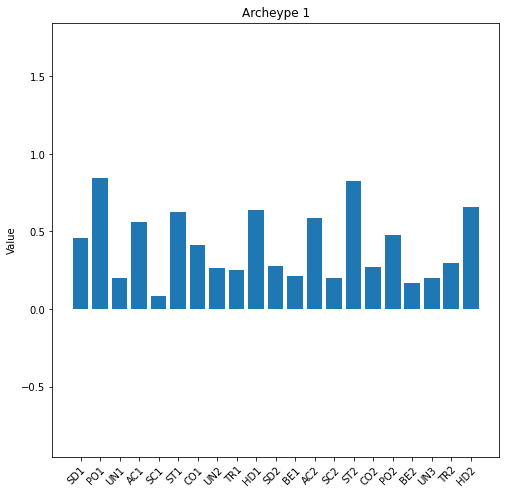

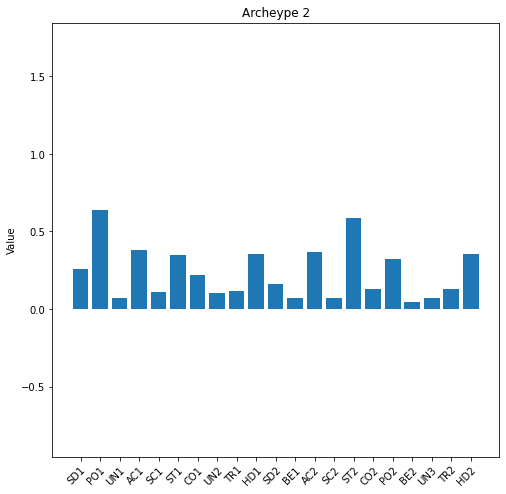

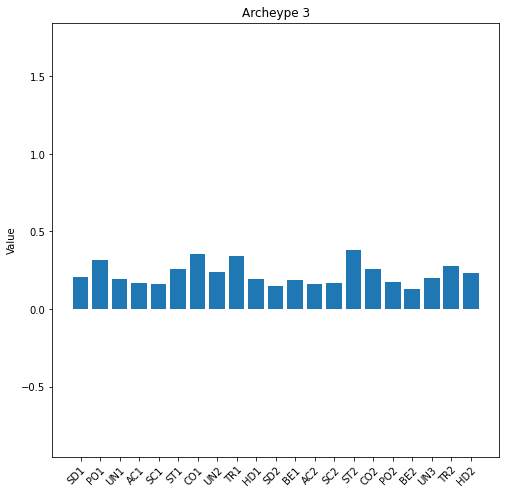

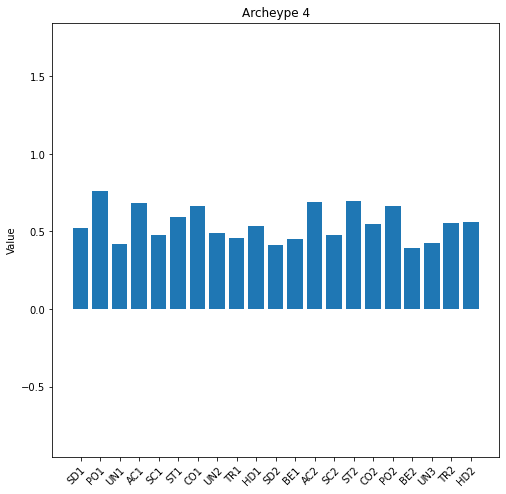

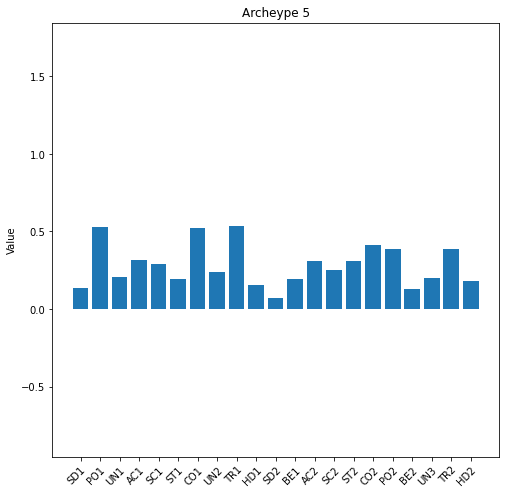

In [134]:
_barplot(Z_tilde,columns)